Nama: Arieldhipta Tarliman

NIM: 2702234636

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Read Dataset

Soruce: https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation?select=Train.csv

Topic: Customer Segment Classification

In [2]:
df = pd.read_csv("Train.csv")

# Simple Data Exploration

In [3]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [5]:
df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


# Check Unique Value

In [6]:
def show_unique_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"Column '{column}' has {len(unique_values)} unique values: {unique_values}\n")


show_unique_values(df)

Column 'ID' has 8068 unique values: [462809 462643 466315 ... 465406 467299 461879]

Column 'Gender' has 2 unique values: ['Male' 'Female']

Column 'Ever_Married' has 3 unique values: ['No' 'Yes' nan]

Column 'Age' has 67 unique values: [22 38 67 40 56 32 33 61 55 26 19 70 58 41 31 79 49 18 36 35 45 42 83 27
 28 47 29 57 76 25 72 48 74 59 39 51 30 63 52 60 68 86 50 43 80 37 46 69
 78 71 82 23 20 85 21 53 62 75 65 89 66 73 77 87 84 81 88]

Column 'Graduated' has 3 unique values: ['No' 'Yes' nan]

Column 'Profession' has 10 unique values: ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]

Column 'Work_Experience' has 16 unique values: [ 1. nan  0.  4.  9. 12.  3. 13.  5.  8. 14.  7.  2.  6. 10. 11.]

Column 'Spending_Score' has 3 unique values: ['Low' 'Average' 'High']

Column 'Family_Size' has 10 unique values: [ 4.  3.  1.  2.  6. nan  5.  8.  7.  9.]

Column 'Var_1' has 8 unique values: ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1

# Handling Column Data Type

In [7]:
df["Work_Experience"] = df["Work_Experience"].astype("Int64")
df["Family_Size"] = df["Family_Size"].astype("Int64").astype("category")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               8068 non-null   int64   
 1   Gender           8068 non-null   object  
 2   Ever_Married     7928 non-null   object  
 3   Age              8068 non-null   int64   
 4   Graduated        7990 non-null   object  
 5   Profession       7944 non-null   object  
 6   Work_Experience  7239 non-null   Int64   
 7   Spending_Score   8068 non-null   object  
 8   Family_Size      7733 non-null   category
 9   Var_1            7992 non-null   object  
 10  Segmentation     8068 non-null   object  
dtypes: Int64(1), category(1), int64(2), object(7)
memory usage: 646.6+ KB


# Handling Missing Values

In [9]:
def missing_value_summary(df):
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    
    missing_summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percentage
    })
    
    missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
    
    return missing_summary

missing_summary = missing_value_summary(df)
missing_summary

,Missing Count,Missing Percentage (%)
Ever_Married,140,1.735250
Graduated,78,0.966782
Profession,124,1.536936
Work_Experience,829,10.275161
Family_Size,335,4.152206
Var_1,76,0.941993


In [10]:
rows_with_missing = df.isnull().any(axis=1).sum()
total_rows = len(df)
remainder_rows = total_rows - rows_with_missing
rows_with_missing_percentage = (rows_with_missing/ total_rows) *100

print(f"Total missing rows = {rows_with_missing} \nTotal rows = {total_rows}\nRemainder rows = {remainder_rows}\nPercentange missing Value = {rows_with_missing_percentage}")

Total missing rows = 1403 
Total rows = 8068
Remainder rows = 6665
Percentange missing Value = 17.38968765493307


I chose to drop the rows with missing values because, although the missing data have 1403 rows, I still have 6665 rows that can be used to train a robust model. With 6665 rows, this is sufficient to capture diverse customer behaviors in each segment without the concern of potential disturbances from imputing values. Given that only about 17% of the data is missing, removing these rows is unlikely to have a significant impact on the overall representativeness of the dataset. Additionally, dropping rows with missing values helps avoid potential bias in columns with missing data, as these columns play a crucial role in the model and could affect the prediction results if the data were forced to be imputed.

In [11]:
df = df.dropna()

In [12]:
missing_value_summary(df)

,Missing Count,Missing Percentage (%)


# Handling Duplicate Values

In [13]:
df[df.duplicated()]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation


# Drop Unused Column

In [14]:
df = df.drop(columns=['ID'])

# Plotting

In [15]:
numerical_colunmns = ['Work_Experience','Age']
categorical_columns = ['Gender', 'Ever_Married', 'Graduated', 'Spending_Score', 'Var_1','Family_Size' ,'Profession' ]

## Categorical Column

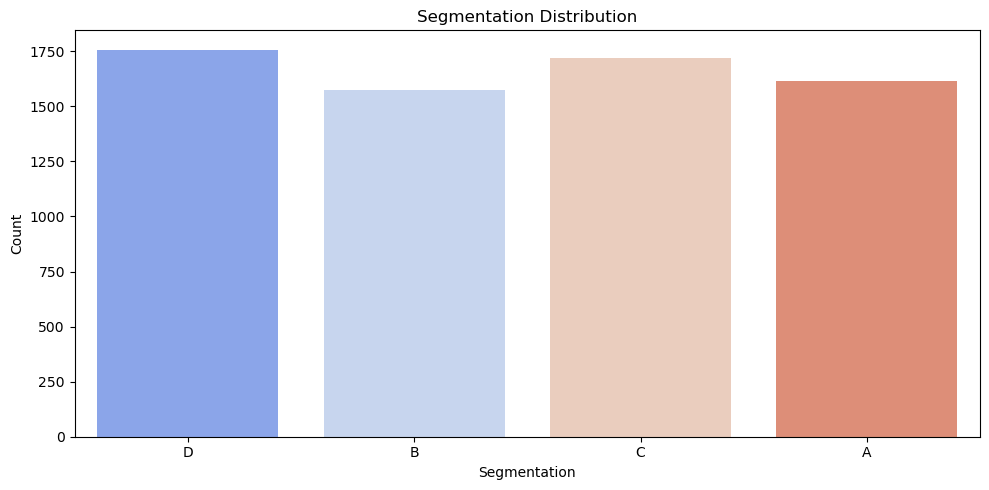

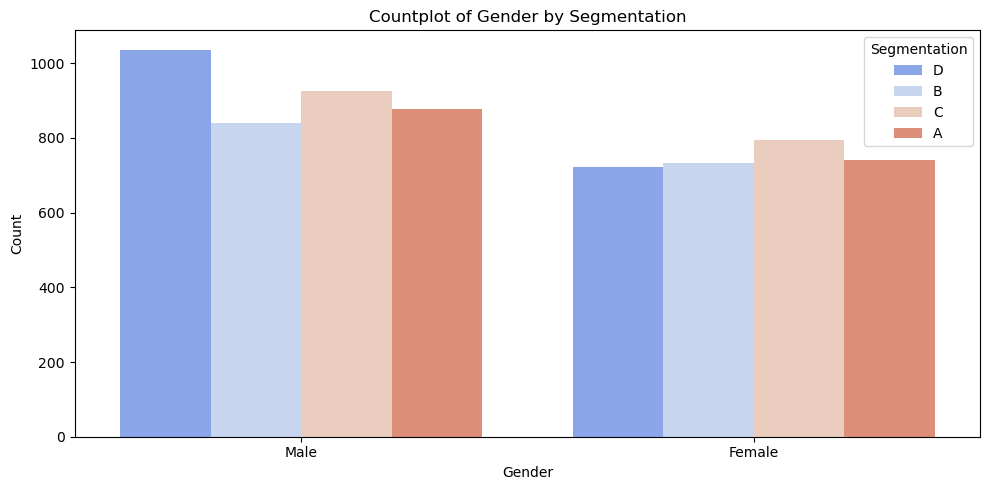

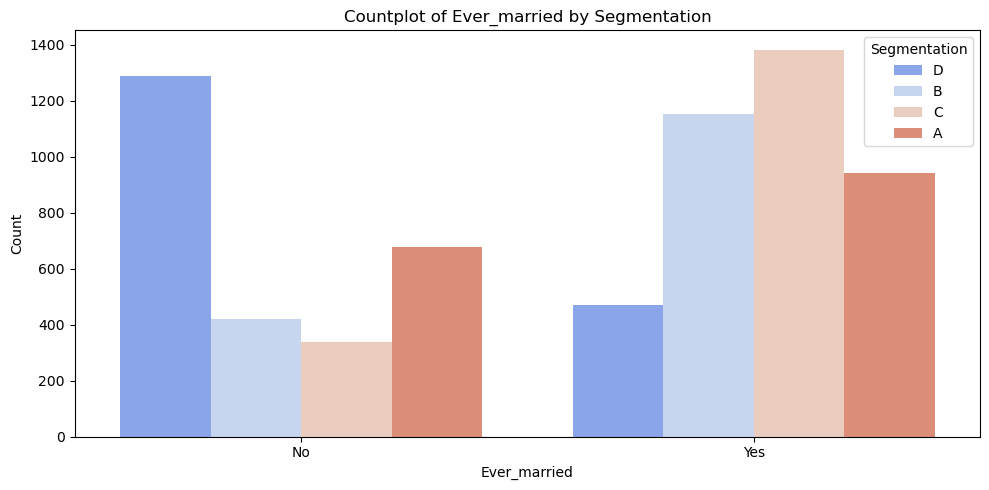

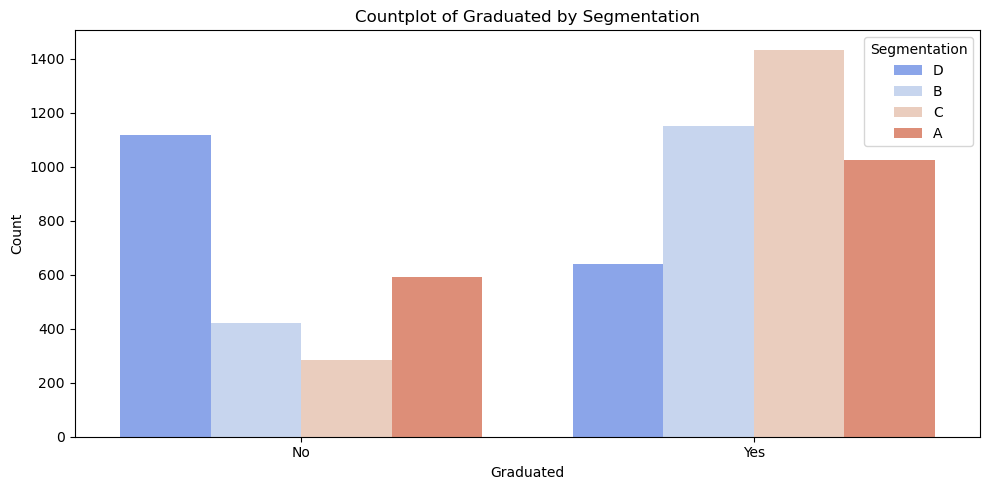

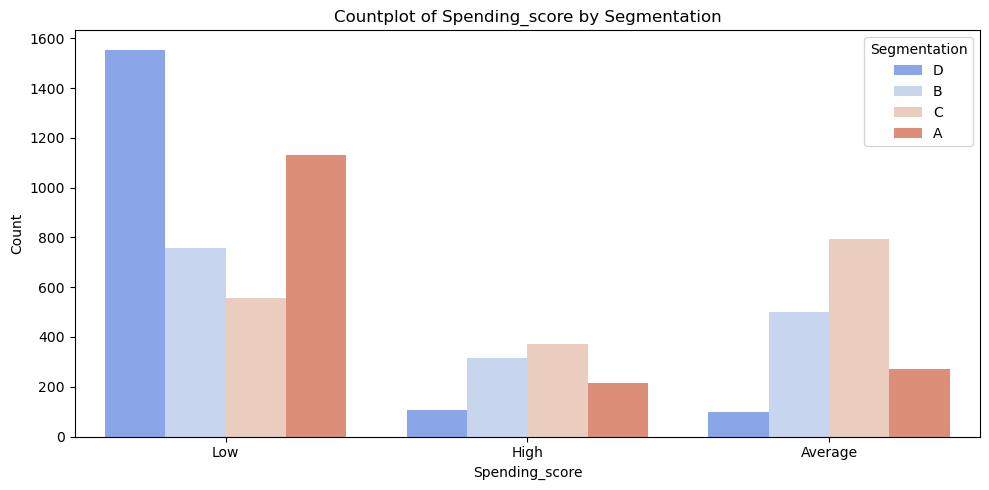

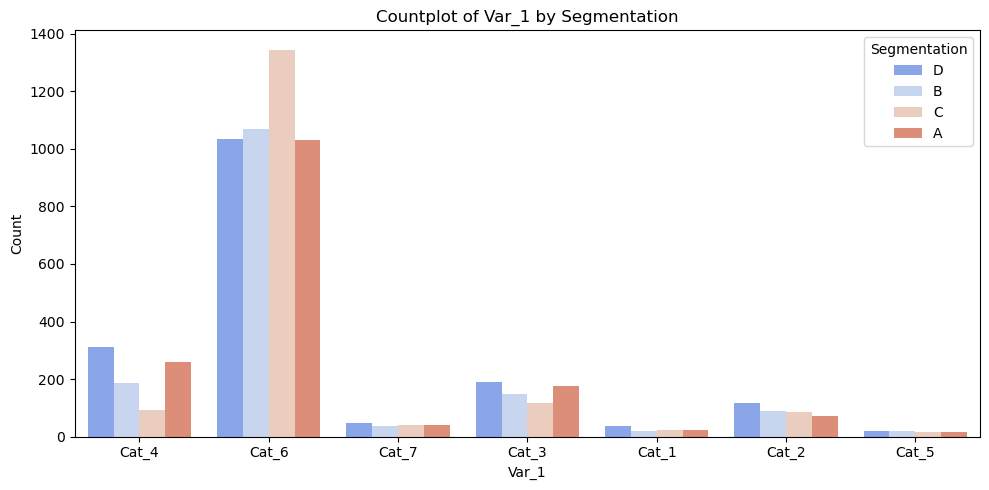

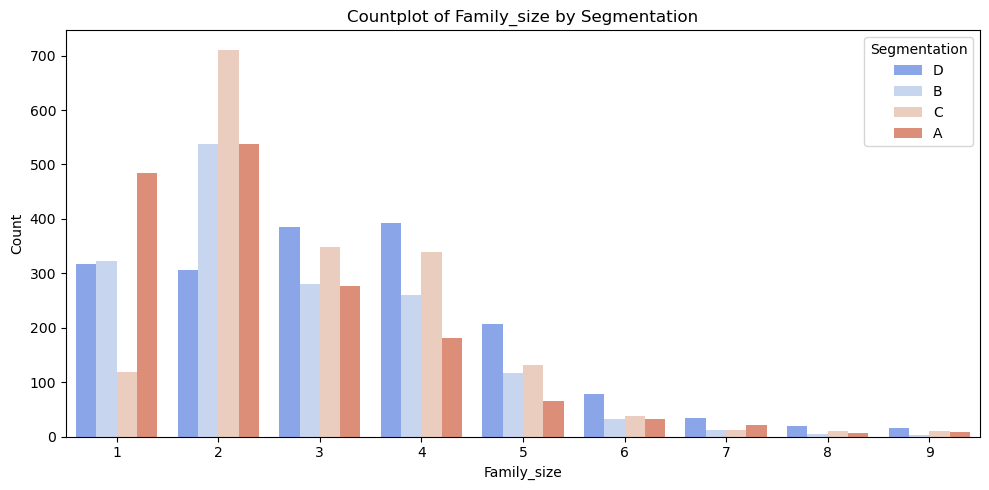

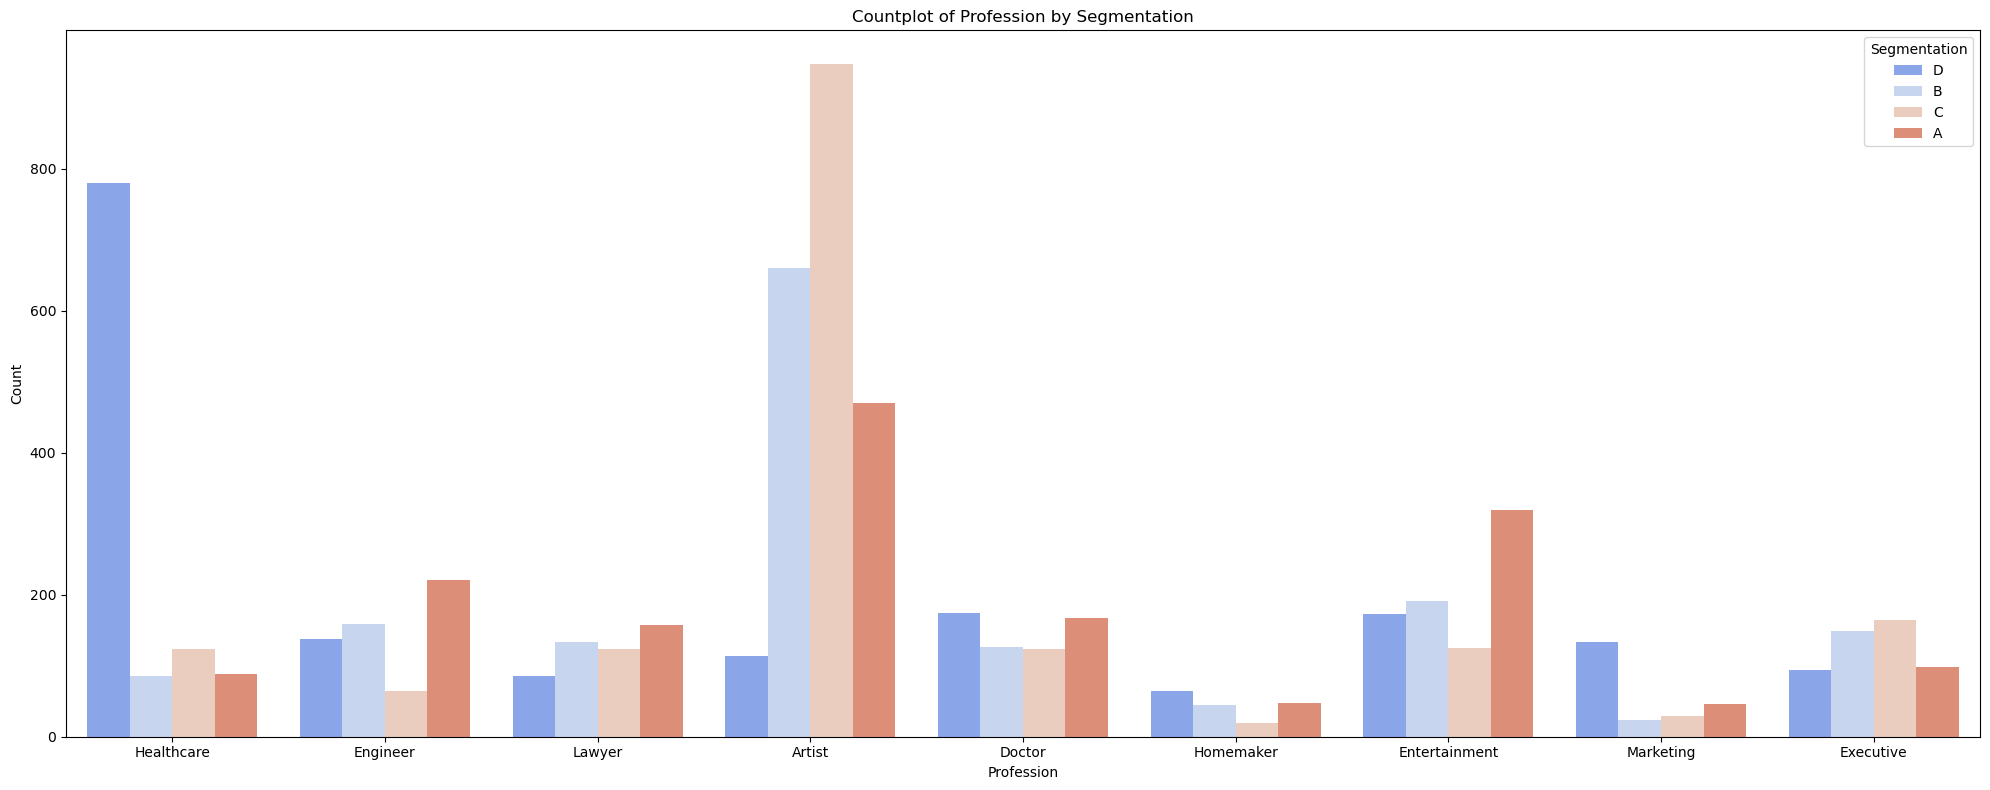

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df['Segmentation'], hue=df['Segmentation'],palette='coolwarm')
plt.title('Segmentation Distribution')
plt.xlabel('Segmentation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

for i, var in enumerate(categorical_columns, 1):
    # Check if the current variable is 'Profession' and change the figure size
    if var == 'Profession':
        plt.figure(figsize=(20, 8))  # Change figure size for 'Profession'
    else:
        plt.figure(figsize=(10, 5))  # Default figure size

    sns.countplot(x=df[var], hue=df['Segmentation'], palette='coolwarm')
    plt.title(f'Countplot of {var.capitalize()} by Segmentation')
    plt.xlabel(var.capitalize())
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()




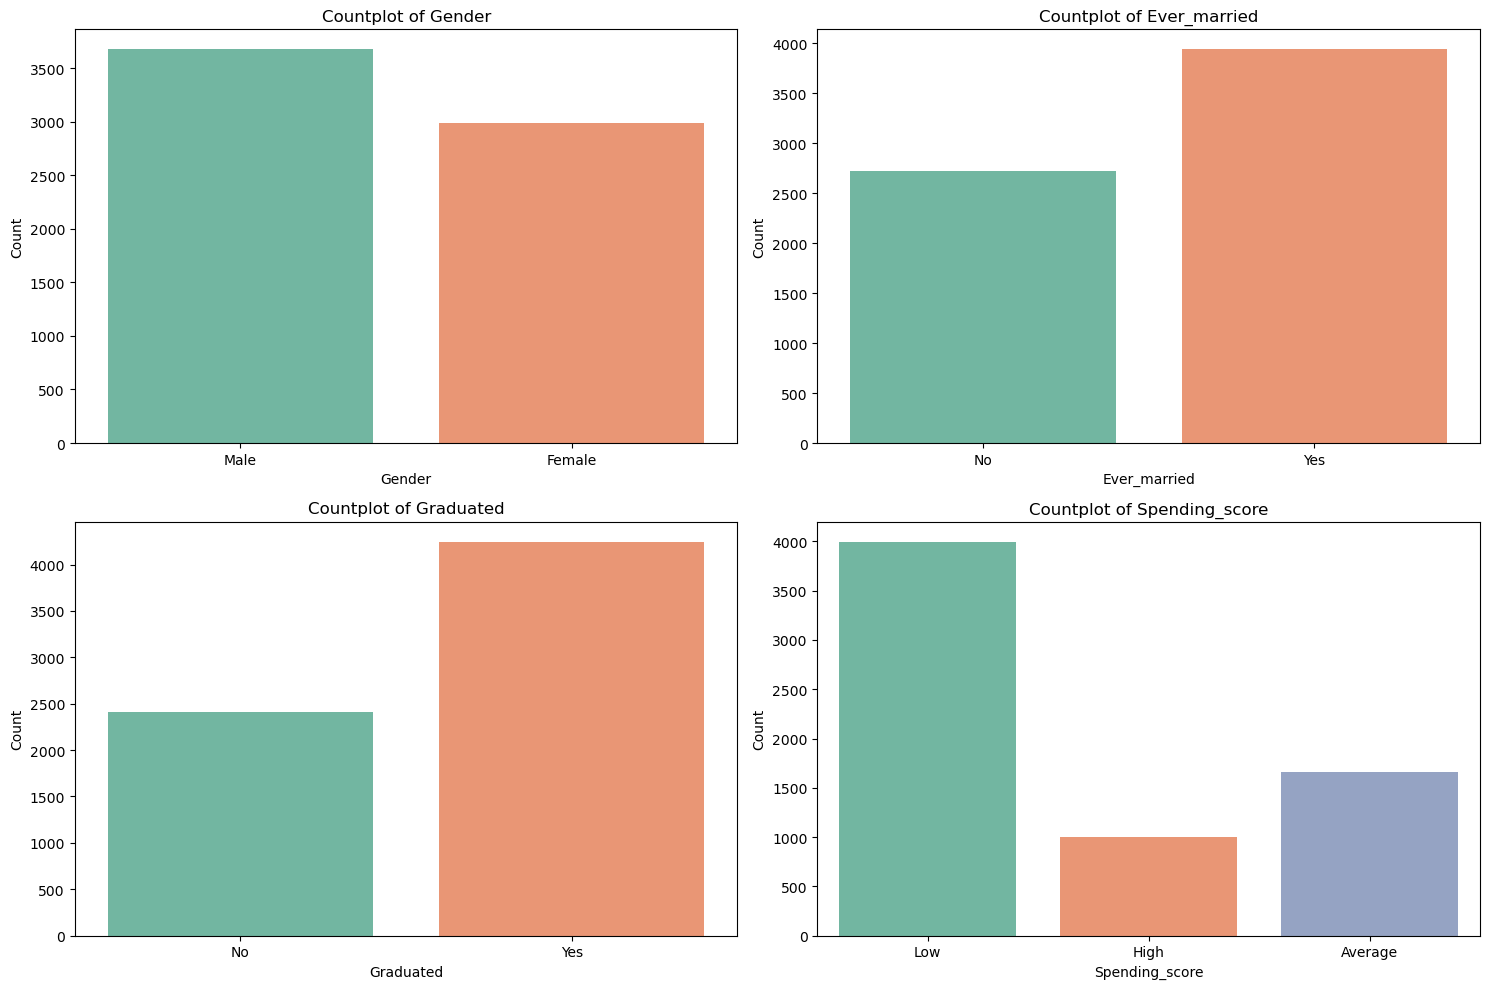

In [17]:
plt.figure(figsize=(15, 10))

target_vars1 = ['Gender', 'Ever_Married', 'Graduated', 'Spending_Score']

# Iterate through categorical columns and create subplots
for i, var in enumerate(target_vars1, 1):
    plt.subplot(2,2, i)  # Subplot for the first four variables in a 3x3 grid
    sns.countplot(x=df[var], hue=df[var], palette='Set2', legend=False)
    plt.title(f'Countplot of {var.capitalize()}')
    plt.xlabel(var.capitalize())
    plt.ylabel('Count')

# Adjust layout for the entire figure
plt.tight_layout()
plt.show()  # Display all the plots in one figure

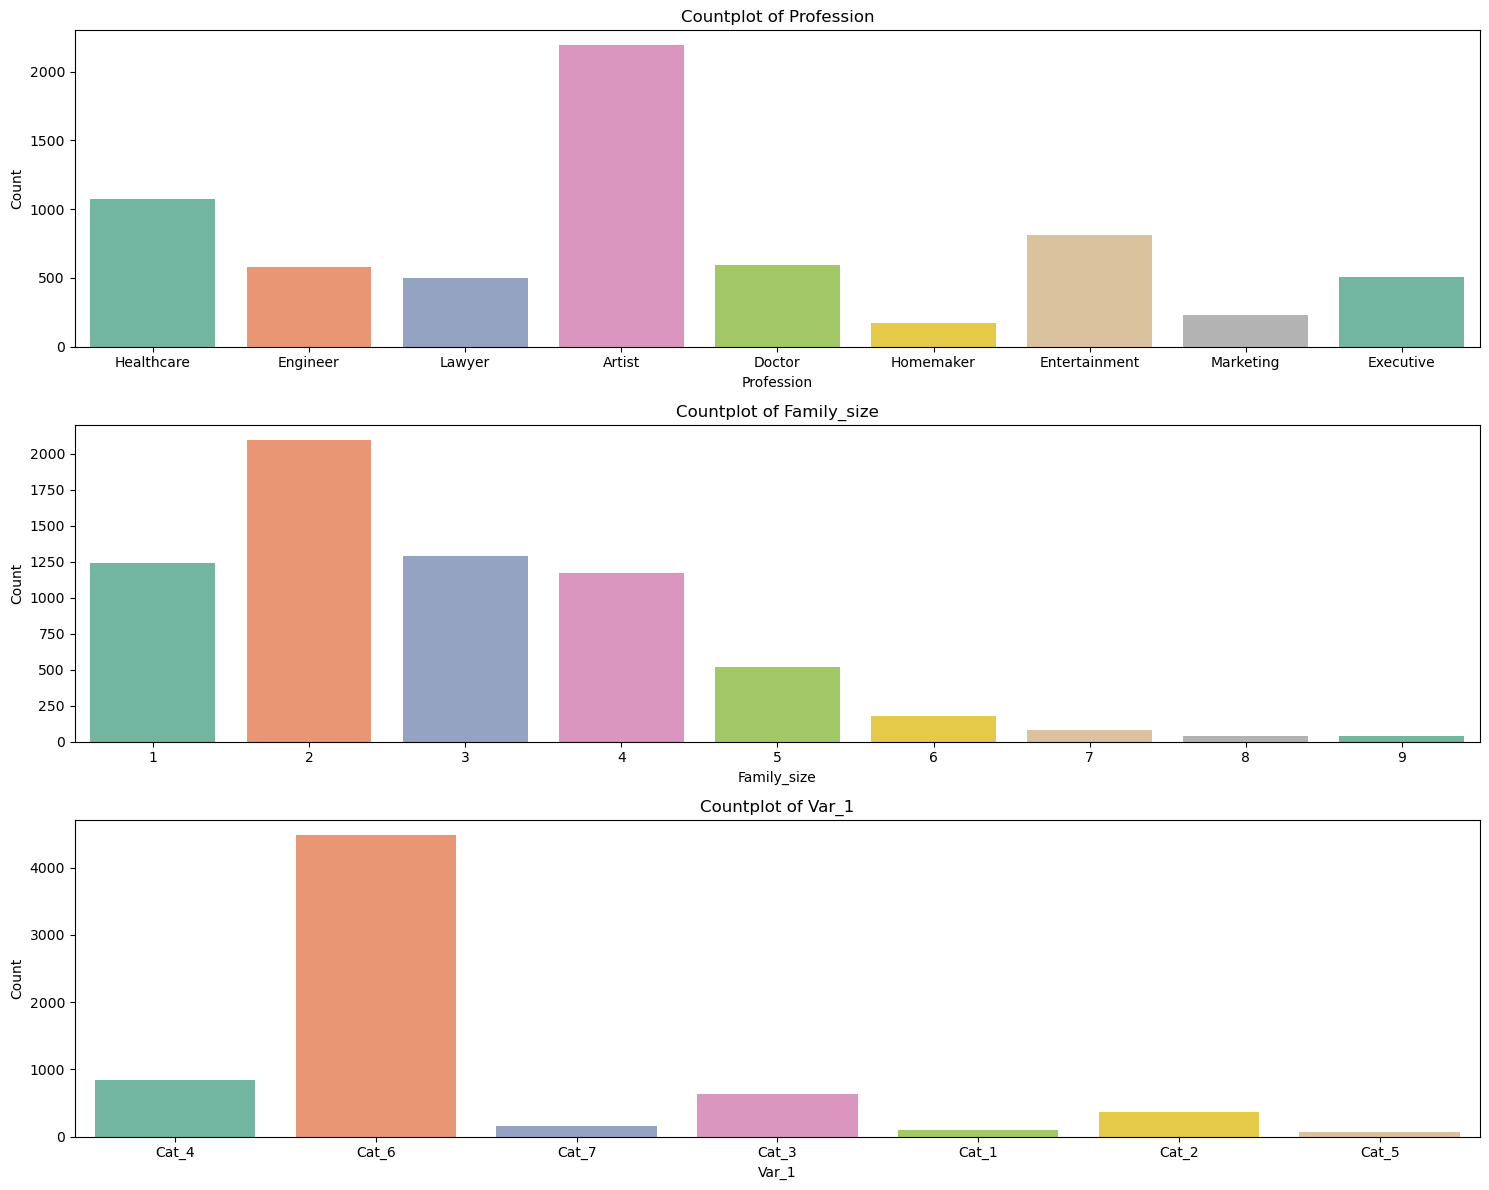

In [18]:
plt.figure(figsize=(15, 12))  

target_vars = ['Profession', 'Family_Size', 'Var_1']

for i, var in enumerate(target_vars, 1):
    plt.subplot(3,1, i)  
    sns.countplot(x=df[var], hue=df[var], palette='Set2', legend=False)
    plt.title(f'Countplot of {var.capitalize()}')
    plt.xlabel(var.capitalize())
    plt.ylabel('Count')

plt.tight_layout()
plt.show()  

From the plotting above abuot all the categorical column, we can simplify that:
1. The target column (Segmentation) does not have an imbalance criteria
2. And most of the data are on cat_6 in var_1 makes the data is far more imbalance based on the plot
3. Also, in the profession column, the data is imbalance because the dominance of the artist profression
4. One thing to notice is that in the plot profession by segmentation, tehre are some imbalance data in each category, example: in healthcare most of it are on segment D

## Numerical Column

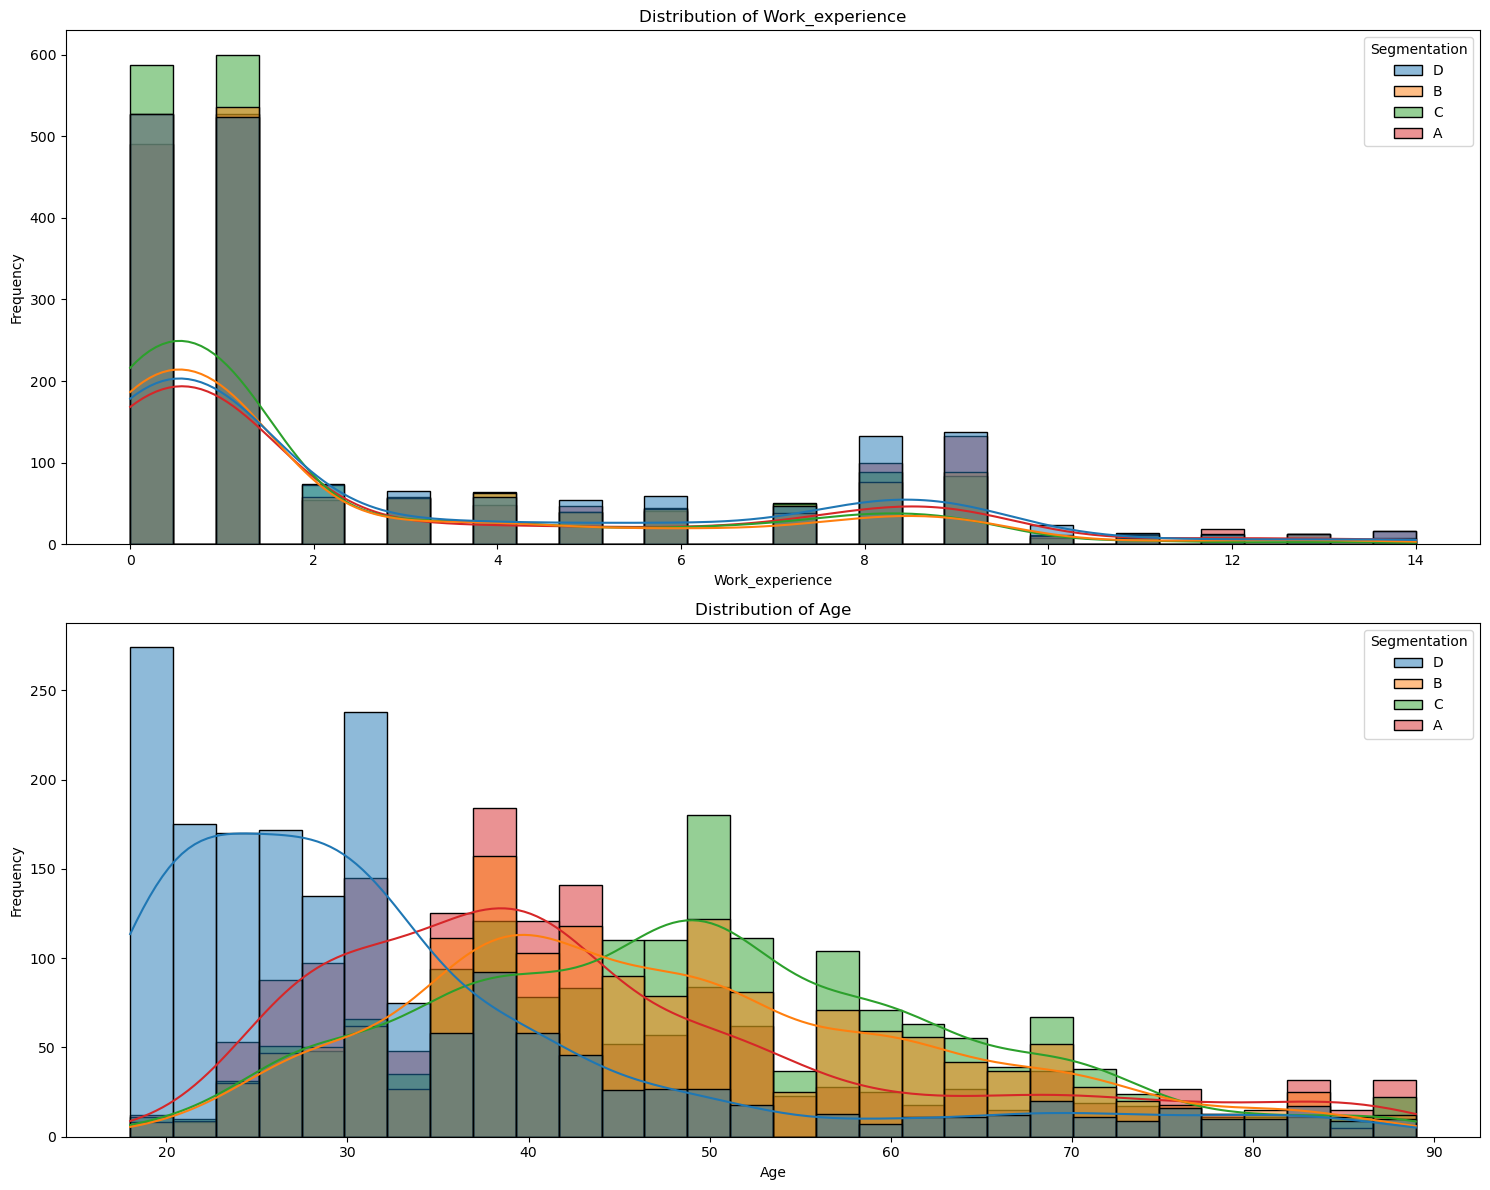

In [19]:
plt.figure(figsize=(15,12))
for i, var in enumerate(numerical_colunmns,1):
    plt.subplot(2,1,i)
    sns.histplot(x = df[var], kde=True, bins=30, hue = df['Segmentation'])
    plt.title(f'Distribution of {var.capitalize()}')
    plt.xlabel(var.capitalize())
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

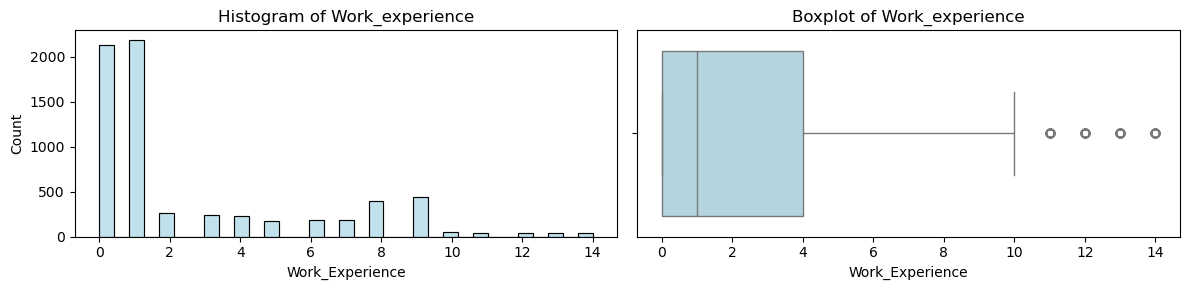

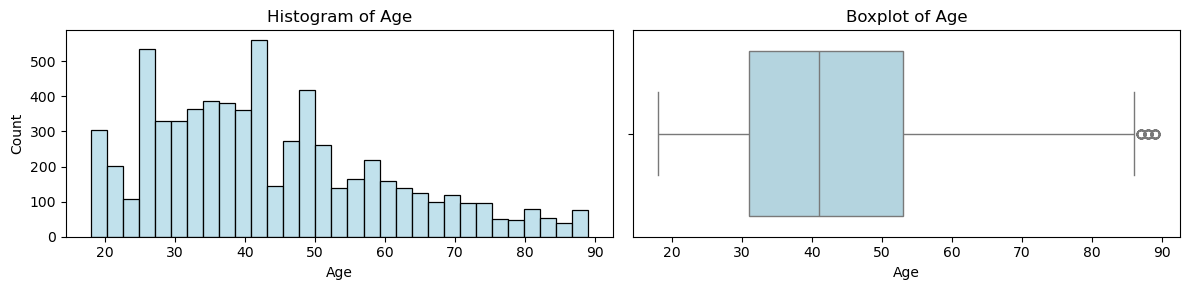

In [20]:
for i, var in enumerate(numerical_colunmns, 1):
    plt.figure(figsize=(12, 3))  
    plt.subplot(1, 2, 1)
    sns.histplot(df[var], color= 'lightblue')  
    plt.title(f"Histogram of {var.capitalize()}")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[var], color= 'lightblue')
    plt.title(f"Boxplot of {var.capitalize()}")
    plt.tight_layout()
    plt.show()

From the Numerical column plot, we can simplify that:
1. The Work_expirience are skewd to the left closer to 0, but there are some of it at 8-10 range, its normal considering the histogram of age also skwed to the left so most of the individual in the data are around 20-50 (roughly)
2. Judging the plot by segmentation, most of the segmentation D are around 20-30, and segmentation A,B,C are slightly normal distributed

### Handling Outliers

In [21]:
for var in numerical_colunmns:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    
    # Print the number of outliers
    print(f"Number of outliers in {var}: {outliers.shape[0]}")
    
    # If there are outliers, print the distinct outlier values
    if outliers.shape[0] > 0:
        # Convert the outlier values to a list and print it
        distinct_outliers = outliers[var].unique().tolist()
        print(f"Distinct outlier values in {var}: {distinct_outliers}")
    print()  # Print a newline for better readability

Number of outliers in Work_Experience: 176
Distinct outlier values in Work_Experience: [12, 13, 14, 11]

Number of outliers in Age: 76
Distinct outlier values in Age: [89, 87, 88]



I will keep the outlier because i use Random Forest and XGBoost that are capable of handling outliers because they work by splitting data based on feature values and are not overly affected by extreme values.

Also, the outliers make up a small percentage of the dataset and the outlier values are not extremely low or high, I decided to keep the outliers. This decision allows for a more accurate representation of the population and helps to avoid biased analysis.



# Data Preparation

## Feature Encoding

### Change Binary Column into Binary Format

I choose to binary encoding theses column because it only contain 2 unique value ach of the column, i dont think it wise to use one hot encoding because it makes unnecesary noise

In [22]:
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Ever_Married'] = df['Ever_Married'].map({'No': 0, 'Yes': 1})
df['Graduated'] = df['Graduated'].map({'No': 0, 'Yes': 1})

### One Hot Encoding for Profession

I used one hot encoding for profession because you cant judge customer importance by their job, with label encoding the number we assign affect the improtant of someone profession. To keep all of it netral i used One hot encoding

In [23]:
df_encoded = pd.get_dummies(df['Profession'], prefix='Profession', drop_first=False)
df = pd.concat([df,df_encoded], axis= 1)
df.drop('Profession', axis= 1, inplace= True)

### Label Encoding for Spending_Score

I used label encoding for spending score because the higher spending score of individual the important it is.

In [24]:
df['Spending_Score'].unique()

array(['Low', 'High', 'Average'], dtype=object)

In [25]:
spending_score_mapping = {'High': 2, 'Average': 1, 'Low': 0}

df['Spending_Score'] = df['Spending_Score'].map(spending_score_mapping)

### Label Encoding for Var 1

Var 1 is Anonymised Category for the customer referse to a  classification of customer data that has been anonymized to protect personal information while still grouping the data in a way that allows for analysis or segmentation.

So there is a possibility that each category has an ordinal relationship. Ordinal data is characterized by a clear ordering or ranking between categories. For example:
1. Income Range
2. Behaviral Segmentatio
3. Geographic Region
4. Product Preferences, etc

Ordinal relationships exist when the categories represent a ranking or ordered scale (e.g., age ranges, income brackets, or behavioral segmentation with levels of engagement). Some categories, like geographic regions or certain product preferences, may not have an inherent order but can still be useful for segmentation and analysis.


In [26]:
df['Var_1'].unique()

array(['Cat_4', 'Cat_6', 'Cat_7', 'Cat_3', 'Cat_1', 'Cat_2', 'Cat_5'],
      dtype=object)

In [27]:
Var_1_mapping = {'Cat_4': 4, 'Cat_6':6, 'Cat_7':7, 'Cat_3':3, 'Cat_1':1, 'Cat_2':2, 'Cat_5':5}
df['Var_1'] = df['Var_1'].map(Var_1_mapping)


### Result

In [28]:
df.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,1,0,22,0,1,0,4,4,D,False,False,False,False,False,True,False,False,False
2,0,1,67,1,1,0,1,6,B,False,False,True,False,False,False,False,False,False
3,1,1,67,1,0,2,2,6,B,False,False,False,False,False,False,False,True,False
5,1,1,56,0,0,1,2,6,C,True,False,False,False,False,False,False,False,False
6,1,0,32,1,1,0,3,6,C,False,False,False,False,False,True,False,False,False


## Split Data

In [29]:
x = df.drop(columns=['Segmentation'])
y = df['Segmentation']

## Correlation Matrix Features Column

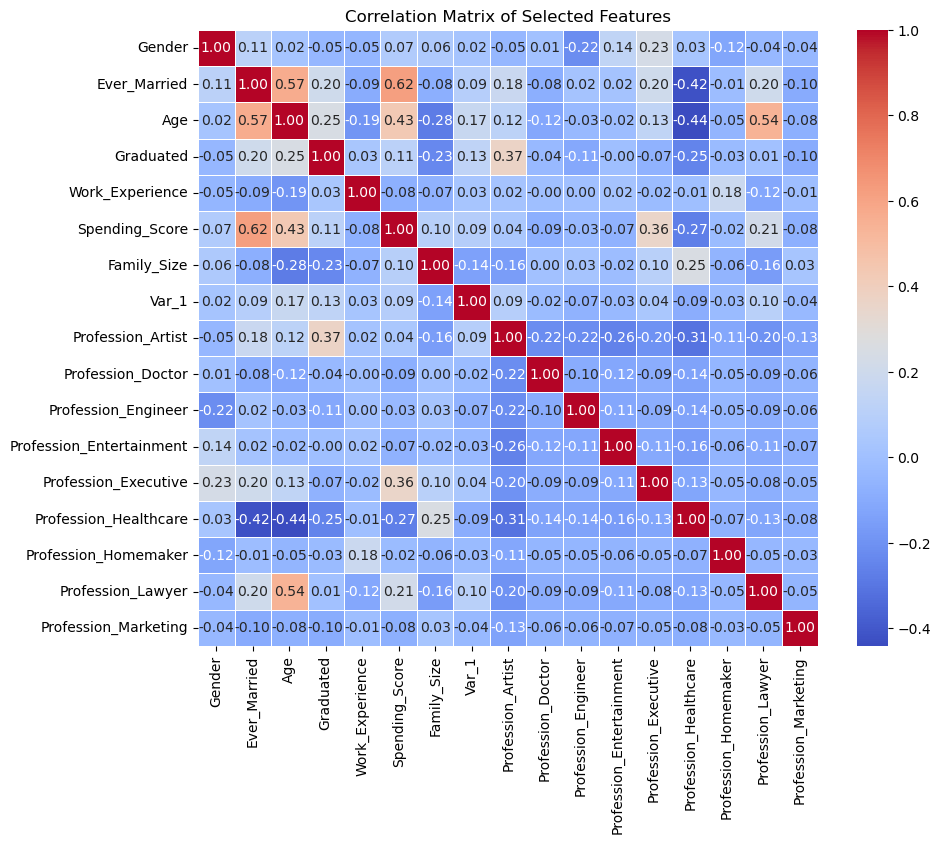

In [30]:
correlation_matrix = x.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()


Conclusion:
1. Spending_Score and Ever_Married(0.62) have the strongest correlation among the features, implying that marital status may influence spending habits.
2. Age and Ever_Married (0.57) are positively correlated, which makes sense because older individuals typically already married.
3. Many of the one-hot encoded profession columns show weak correlations with other features. However, Profession_Lawyer has a strong positive correlation (0.54) with Age, indicating that lawyers tend to have older individuals.
4. Profession_Healthcare has negative correlations with Ever_Married (-0.42) and Age (-0.44). This suggests that individuals in the healthcare profession tend to be younger and less likely to be married, compared to individuals in other professions.

# Check for data imbalance

In [31]:
print(y.value_counts(normalize=True))


Segmentation
D    0.263616
C    0.258065
A    0.242461
B    0.235859
Name: proportion, dtype: float64


Since no class drops below 20%, applying SMOTE might not be necessary.

# Modelling

## Why i value F1-Score

In this model, iam more focused on the result of f1-score. F1-score is the harmonic mean of precission and recall because both metrics are equally imprtant. 

By example:
- Precission is important because of the false positive, to reduce marketing waste and ensuring outreach efforts target to the right customer. In most automobile one of the easiest way and costlyto gain a customer is by marketing it. 
    - Example: The automobile company launches an exclusive marketing campaign for high-value customers in Segment A. This campaign involves personalized gifts or invitations to exclusive product launch events, which are costly.
        - If the model wrongly classifies low-value customers as belonging to Segment A (false positives), resources are wasted on individuals who may not contribute much revenue.
        - High precision ensures the campaign targets only the right customers, reducing resource wastage.
- Recall is also important becaue of the false negatives.
    - Example: The company identifies customers in Segment B as those likely to switch to competitors. These customers need targeted retention offers, such as discounts, loyalty benefits, or trade-in deals.
        - If the model fails to identify actual Segment B customers (false negatives), the company risks losing them to competitors.
        - High recall ensures all at-risk customers are captured for retention efforts, even if some irrelevant ones are mistakenly included.

From both explanation i think both are equally important. The marketing team needs to ensure campaigns are efficient (precision) while retaining as many high-value or at-risk customers as possible (recall).


In [32]:
xtrain, xtest, ytrain,ytest = train_test_split(x,y,test_size= 0.2, random_state= 42)

## Random Forest Classifier

In [33]:
rf= RandomForestClassifier()
rf.fit(xtrain,ytrain)
ypred = rf.predict(xtest)

### Evaluate the model

In [34]:
accuracy = accuracy_score(ytest, ypred)
conf_matrix = confusion_matrix(ytest, ypred)
class_report = classification_report(ytest, ypred)

print(f'Accuracy: {accuracy:}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.4846211552888222
Confusion Matrix:
[[134  63  47  71]
 [ 69 103  96  34]
 [ 45  93 173  35]
 [ 81  26  27 236]]
Classification Report:
              precision    recall  f1-score   support

           A       0.41      0.43      0.42       315
           B       0.36      0.34      0.35       302
           C       0.50      0.50      0.50       346
           D       0.63      0.64      0.63       370

    accuracy                           0.48      1333
   macro avg       0.48      0.48      0.48      1333
weighted avg       0.48      0.48      0.48      1333



The model correctly predicted the customer segment (class) for about 49% of the instances in the dataset. An accuracy of  <50% suggests that the model is only slightly better than random guessing, indicating room for improvement.

And the breakdown of confusion matrix are:
1. Class A: The model predicted 136 instances correctly as Class A. However, it incorrectly predicted 67 as B, 46 as C, and 66 as D.
2. Class B: The model predicted 104 instances correctly as Class B, but it misclassified 69 as A, 99 as C, and 30 as D.
3. Class C: The model predicted 177 instances correctly as Class C, with misclassifications in 39 as A, 88 as B, and 42 as D.
4. Class D: The model predicted 237 instances correctly as Class D, with misclassifications in 79 as A, 25 as B, and 29 as C.
5. The diagonal of the matrix (i.e., the values 136, 104, 177, 237) represents the number of correct predictions for each class.

From the clasification report, I am more concerned with the f1-score results.  The F1-score is the harmonic mean of precision and recall. 
1. Class A and Class C perform well with balance precision and recall
2. Class B has the lowest value, meaning the model struggle with class B
3.  The model performs best on Class D, with the highest precision, recall, and F1-score, suggesting it can reliably classify this segment.

I also concerned about macro avg because it calculates the average performance across all classes without considering class imbalance. 
The model's average precision, recall, and F1-score are around 0.48, which is relatively low, indicating that the model is not performing well across the board.

In conclusion, the model need hyperparameter tuning to improve it

### Fine Tuning

GridSearchCV performs an exhaustive search over a specified parameter grid, evaluating all possible combinations of hyperparameters using cross-validation.

In [35]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1_macro', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(xtrain, ytrain)

best_rf = grid_search.best_estimator_
ypred = best_rf.predict(xtest)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [36]:
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(ytest, ypred))
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred))
print("Classification Report:\n", classification_report(ytest, ypred))

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.5341335333833458
Confusion Matrix:
 [[150  58  41  66]
 [ 71 107  92  32]
 [ 37  63 198  48]
 [ 83  19  11 257]]
Classification Report:
               precision    recall  f1-score   support

           A       0.44      0.48      0.46       315
           B       0.43      0.35      0.39       302
           C       0.58      0.57      0.58       346
           D       0.64      0.69      0.66       370

    accuracy                           0.53      1333
   macro avg       0.52      0.52      0.52      1333
weighted avg       0.53      0.53      0.53      1333



After fine tuning, the result have a great improvement.
- By confusion matrix, almost all segmentation has improved in correct prediction (154,101,199,260)

The f1-score each segment also improve significantlly for example:
- Class A from 0.43 to 0.46
- Class B from 0.35 to 0.37
- Class C from 0.51 to 0.58
- Class D from 0.0.64 to 0.68

Also, the macro avg precision, recallm adn more importantly f1-score imporeve from 0.48 to 0.52

Those signification result means by doing fine tuning with gridsearchcv improve the model positivelly

But, there are still some room for improvement. My lecturer told me that if you dont know what model use some boost. (not exactly what he said but that what i understand). So then we can try to use some XGBoost model

## XGBoost Algorithm

In [37]:
y_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}  
y_encoded = y.map(y_mapping)
x['Family_Size'] = x['Family_Size'].astype('int')
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

In [38]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  
    num_class=4,                
    random_state=42,
)

xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)


### Evaluate the model

In [39]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5033758439609902
Confusion Matrix:
 [[132  70  44  69]
 [ 75  91 107  29]
 [ 41  65 201  39]
 [ 79  22  22 247]]
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.42      0.41       315
           1       0.37      0.30      0.33       302
           2       0.54      0.58      0.56       346
           3       0.64      0.67      0.66       370

    accuracy                           0.50      1333
   macro avg       0.49      0.49      0.49      1333
weighted avg       0.50      0.50      0.50      1333



### Compare the model xgboost and random forest

Lets start with the accuracy where XGBoost has a slightly higher accuracy (50.34%) compared to Random Forest (49.06%)

On Confusion Matrix, here are my analysis:
- Class D: Both models perform well on Class D with XGBoost having a slightly better precision and recall. XGBoost predicts 247 instances as Class D correctly, while Random Forest predicts 237 correctly.
- Class A: For Class A, Random Forest performs better, with 136 correct predictions vs. 132 for XGBoost. XGBoost misclassifies 75 as Class B, whereas Random Forest misclassifies 69 as Class B, showing that Random Forest has a slightly better performance for Class A.
- Class B: Both models have difficulty with Class B. XGBoost has 37% precision and 30% recall, while Random Forest's precision and recall are similar (37% and 34%). Neither model is performing well on this class.
- Class C: XGBoost slightly outperforms Random Forest for Class C, with 54% precision and 58% recall compared to Random Forest's 50% precision and 51% recall.

On the Classification Report:
- Class A: Random Forest performs slightly better than XGBoost for Class A in terms of precision and recall.
- Class B: Both models struggle with Class B. They have low precision and recall, but XGBoost has slightly lower recall, indicating it misses more instances of this class.
- Class C: XGBoost outperforms Random Forest for Class C with better precision (0.54 vs. 0.50) and recall (0.58 vs. 0.51), indicating better classification.
- Class D: Both models perform similarly for Class D, with XGBoost showing slightly higher recall (0.67 vs. 0.64) and precision (0.64 vs. 0.63).

On  the macro avg the xgboost model have a slightly better result by +1 than random forest, indicating that it has better overall performance when considering all classes equally.

Overall, xgboost perform better than random forest

### Fine Tuning

For XGBoost, RandomizedSearchCV is often the better choice because of its efficiency and ability to explore a broader hyperparameter space.

In [40]:
param_grid_2 = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'gamma': [0, 0.1, 0.2, 1],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0, 0.1, 1]
}

In [41]:
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid_2, 
                                   n_iter=100, cv=5, scoring='f1_macro', 
                                   verbose=2, random_state=42, n_jobs=-1)
random_search.fit(x_train, y_train)
best_model_2 = random_search.best_estimator_
y_pred_best = best_model_2.predict(x_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [42]:
print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Best Parameters: {'subsample': 1, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8, 'alpha': 0.1}
Accuracy: 0.5431357839459865
Confusion Matrix:
 [[153  61  37  64]
 [ 70 102 100  30]
 [ 40  49 211  46]
 [ 81  19  12 258]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.49      0.46       315
           1       0.44      0.34      0.38       302
           2       0.59      0.61      0.60       346
           3       0.65      0.70      0.67       370

    accuracy                           0.54      1333
   macro avg       0.53      0.53      0.53      1333
weighted avg       0.54      0.54      0.54      1333



### Compare the model xgboost before and  after fine tuning

After fine tuning, the conclution:

On the Confusion Matrix:
-  Class 0 (A): Correct predictions improved from 132 to 153. Misclassifications to other classes decreased overall. Indicates the model is better at distinguishing Class 0 after fine-tuning.
- Class 1 (B): Correct predictions improved slightly from 91 to 102, but misclassifications to Class 2 remain high (100 after fine-tuning).
- Class 2 (C): Correct predictions increased from 201 to 211. Misclassifications to Class 1 (B) and Class 3 (D) reduced after fine-tuning.
- Class 3 (D): Correct predictions improved from 247 to 258, showing better performance for this class.

On the Classification Report:
- Class 0 (A): F1-score improved from 0.41 to 0.46, indicating better precision and recall for this class after fine-tuning.
- Class 1 (B): F1-score improved from 0.33 to 0.38, but this class remains the weakest, with relatively low recall (34%).
- Class 2 (C): F1-score improved from 0.56 to 0.60, showing better classification for this class.
- Class 3 (D): F1-score improved slightly from 0.66 to 0.67, maintaining strong performance for this class.

Last, both on macro and weighted averages improved by approximately 4%, reflecting overall gains in precision, recall, and F1-scores for the model.

# Compare  model Random Forest & XGBoost after fine tuning

Overall, XGBoost slightly outperfroms Random Forest in almost everything.

1. XGBoost slightly outperforms Random Forest in accuracy, precision, and F1-score across both macro and weighted averages.
2. Both actually has similarly in recall, with macro and weighted averages are the same at 53 & 54 %
3. On the Classification report, XGBoost consistently have a great performance for class B, C, D. Performs better at predicting class B which in random forest it struggles to predict correctly. Meanawhiile, on class A both have the same perfromance
4. XGBoost also have a better benefits from hyperparameter tuning

# Compare with ROC Curve

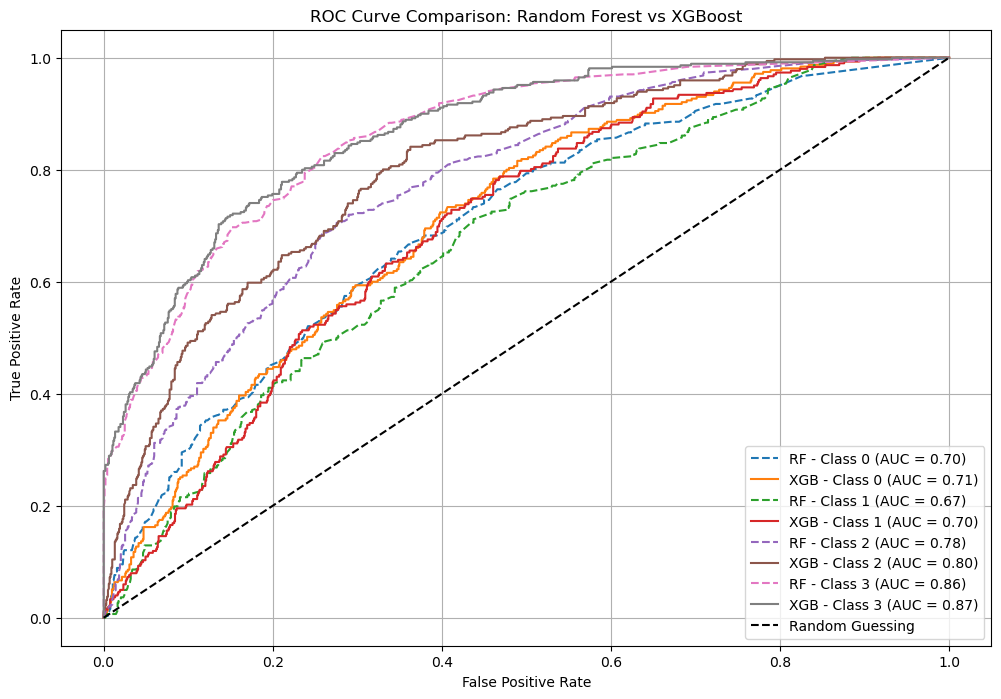

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Assuming X_test, y_test, rf_model, xgb_model are defined
# Get probabilities for both models
rf_probs = rf.predict_proba(x_test)
xgb_probs = xgb_model.predict_proba(x_test)

# Binarize the true labels
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

# Initialize a figure
plt.figure(figsize=(12, 8))

# Plot ROC curves for each class
for i, class_name in enumerate(lb.classes_):
    # Compute ROC for Random Forest
    rf_fpr, rf_tpr, _ = roc_curve(y_test_binarized[:, i], rf_probs[:, i])
    rf_auc = auc(rf_fpr, rf_tpr)

    # Compute ROC for XGBoost
    xgb_fpr, xgb_tpr, _ = roc_curve(y_test_binarized[:, i], xgb_probs[:, i])
    xgb_auc = auc(xgb_fpr, xgb_tpr)

    # Plot ROC curve for this class
    plt.plot(rf_fpr, rf_tpr, linestyle='--', label=f'RF - Class {class_name} (AUC = {rf_auc:.2f})')
    plt.plot(xgb_fpr, xgb_tpr, linestyle='-', label=f'XGB - Class {class_name} (AUC = {xgb_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title('ROC Curve Comparison: Random Forest vs XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


- Both models perform best for Class 3 (highest AUC values: 0.86 for RF, 0.87 for XGB).
- Class 0: RF and XGB perform equally well with AUC = 0.71.
- Class 1: XGB (AUC = 0.70) slightly outperforms RF (AUC = 0.67).
- Class 2: XGB (AUC = 0.80) outperforms RF (AUC = 0.78).
- Class 3: XGB (AUC = 0.87) slightly outperforms RF (AUC = 0.86).


# Conclusion

From the few poin that i mention, XGBoost and Random Forest diffrences in performance are not drastic.But, using XGBoost is more ideal for me to used because of its better balanced performanced for every class. This also supported with ROC curve each classes where XBG outperforms RF for class B, C, D and tied for class A. This demonstrates that XGBoost has a better overall capability to differentiate between the classes.

# BONUS Question

## 3. XGBoost is a boosting algorithm based on tree-based models. It has a mechanism to display 3 types of feature importance: (1) gain, (2) weight, & (3) coverage. Explain each of them (max. 3 points)


Gain represents the average improvement in the model’s accuracy (or reduction in loss) when a feature is used for splitting. Features with high gain have a significant impact on improving the model's predictive power, making this metric ideal for understanding which features contribute the most to performance. 

Weight, on the other hand, counts how often a feature is used to split the data across all the trees. Although it indicates how frequently a feature is selected, it doesn’t necessarily reflect the feature’s overall impact. 

Finally, coverage measures the proportion of data samples influenced by a feature during splits, highlighting how broadly applicable the feature is in the decision-making process.

## 4. There is a joke among data scientists, "when in doubt, use XGBoost" - Owen Zhang. State the reasons and in what scenarios will XGBoost perform badly! (max. 3 points)


- XGBoost often delivers top-notch performance due to its boosting approach, which combines multiple weak learners into a strong ensemble model. 
- It includes built-in regularization techniques (like L1 and L2 penalties) to reduce overfitting, making it effective for both small and large datasets. 
- Additionally, its ability to natively handle missing values and work efficiently with numerical and encoded categorical data makes it highly adaptable. 
- XGBoost is also known for its speed, thanks to parallel processing, out-of-core computation, and early stopping, which optimize runtime.

Limitation:
- Struggle with small datasets where simpler algorithms. Logistic regression or SVMs, might perform equally well or better due to their lower complexity.
- Linear models utperforms XGBoost in high dimensional sparse features(text data)
- If the dataset is highly imbalanced, XGBoost might prioritize the majority class unless appropriate class balancing techniques are applied.

## 5. Tell me a joke related to ensembling or tree-based algorithms (max. 1 point)


Bagging is one of the machine learning techniques worth learning to improve the model. However, begging our model remains the most important aspect.